Selective Search
================
Saber dónde existe un objeto en una imágen es una tarea muy complicada. Para ello, se utilizan métodos de segmentación que dividen la imágen en regiones y clasificarlas mediante una CNN. El método de segmentación más utilizado es el de Selective Search, que consiste en dividir la imágen en regiones de diferentes tamaños y formas, fusionarlas según su similitud y pasarlas a una CNN para descartar las que no contienen objetos. Veamos la siguiente imagen:

<center>

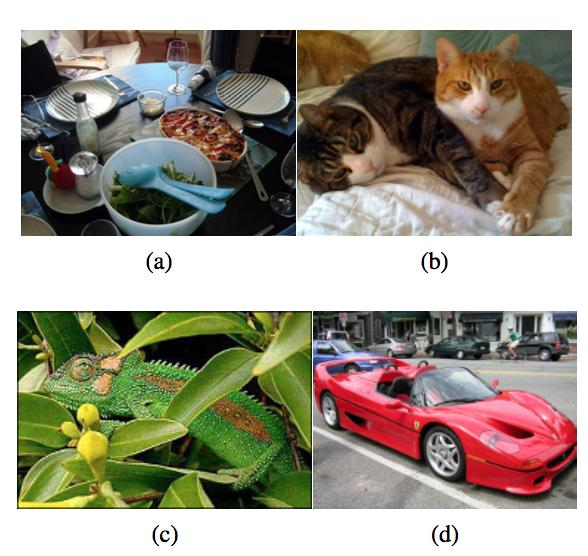

</center>

Tenemos cuatro casos:

a) Existe una relación jerárquica entre objetos: la cuchara en el tazón.

b) Se puede usar el color para separar a los gatos pero no la textura.

c) Se puede distinguir al camaleón por la textura pero no por el color.

d) Las llantas son parte del carro aunque no sean similares en color y textura.

Esto nos indica que tenemos que considerar varios criterios a la hora de querer combinar las regiones. El algoritmo es el siguiente:

1.- Generar el conjunto de regiones $R$ inicial.
2.- Inicializar un conjunto $S$ vacío similar a $R$.
3.- Calcular la similitud entre las regiones adyacentes y agregarlas a $S$.
4.- Encontrar el par de regiones más similares en $S$ y fusionarlas, eliminarlas de $S$ y agregar la región fusionada a $R$.
5.- Calcular la similitud entre la región fusionada y el área circundante, y agregarlas a $S$ 
6.- Mientras $S$ no esté vacío, repetir los pasos 4 y 5.
7.- Encontrar el cuadro delimitador de todas las áreas de $R$.

* Similitud de color: se usa la normalización L1 en cada canal de color de la imagen y obtener el histograma $(c_i^1,...,c_i^n)$, luego se calcula $S_{color}(r_i, r_j) = \Sigma_{k=1}^{n} min(c_i^k, c_j^k)$. Al fusionar dos regiones, se calcula el nuevo vector de colores $c_t=\frac{size(r_i) \times c_i + size(r_j) \times c_j}{size(r_i)+size(r_j)}$.

* Similitud de textura: se aplica la función de textura SIFT-Like (donde se calcula la variación para canal de color en 9 direcciones con el diferencial gaussiano), posteriormente se aplica la normalización L1 y obtener un histograma $(t_i^1,...,t_i^n)$, luego se calcula $S_{texture}(r_i, r_j) = \Sigma_{k=1}^{n} min(t_i^k, t_j^k)$. Al fusionar dos regiones, se calcula el nuevo vector de textura $t_t=\frac{size(r_i) \times t_i + size(r_j) \times t_j}{size(r_i) + size(r_j)}$.

* Priorizar áreas pequeñas: si solo se combinan regiones grandes, se perderá información de las pequeñas. Para evitar esto, daremos más peso a las áreas pequeñas mediante $S_{size}(r_i, r_j) = 1 - \frac{size(r_i) + size(r_j)}{size(im)}$.

* Distancia de ajuste: si el área $r_i$ está dentro de $r_j$, debemos fusionarlas primero. Primero se define un bounding box $BB_{ij}$ que contiene a $r_i$ y $r_j$, luego, se calcula la distancia de ajuste $S_{fill}(r_i, r_j) = 1 - \frac{size(BB_{ij}) - size(r_i) - size(r_j)}{size(im)}$.

Estas cuatro similitudes se unen en una combinación lineal tal que $S(r_i, r_j) = \alpha S_{color}(r_i, r_j) + \beta S_{texture}(r_i, r_j) + \gamma S_{size}(r_i, r_j) + \delta S_{fill}(r_i, r_j)$.

Para cada categoría $c$, cada verdad fundamental (también conocida como ground-truth es la región que contiene al objeto etiquetada) se expresa como $g_i^c \in G^c$. Con esto se mide el rendimiento de la búsqueda selectiva, donde el indicador ABO (Average Best Overlap) se define como: $ABO = \frac{1}{|G^c|} \Sigma_{g_i^c \in G^c} max(IoU(g_i^c, l^j))$. 

Implementación
==============

In [2]:
import skimage.io as io
import numpy as np
from scipy.ndimage import find_objects
from skimage.segmentation import find_boundaries
from skimage.feature import local_binary_pattern
from skimage.segmentation import felzenszwalb

# Generamos una imagen que busque el espectro de texturas
def generate_lbp_image(img):
                       
    if len(img.shape) == 2: 
        img = img.reshape(img.shape[0], img.shape[1], 1)

    channels = img.shape[2]
    lbp_img = np.zeros(img.shape)

    for c in range(channels):
        layer = img[:, :, c]
        lbp_img[:, :, c] = local_binary_pattern(layer, 8, 1, method="uniform")

    return lbp_img

# Formulas de similitud

def color_sim(ri, rj):
    return sum([min(a, b) for a, b in zip(ri["color_hist"], rj["color_hist"])])

def texture_sim(ri, rj):
    return sum([min(a, b) for a, b in zip(ri["texture_hist"], rj["texture_hist"])])

def size_sim(ri, rj, img_size):
    return 1 - ((ri["size"] + rj["size"]) / img_size)

def fill_sim(ri, rj, img_size):
    bbsize = (max(ri["box"][2], rj["box"][2]) - min(ri["box"][0], rj["box"][0])) * (max(ri["box"][3], rj["box"][3]) - min(ri["box"][1], rj["box"][1]))
    return 1 - ((bbsize - ri["size"] - rj["size"]) / img_size)

# Calculamos el histograma de color

def color_hist(mask, img):

    BINS = 25
    if len(img.shape) == 2: 
        img = img.reshape(img.shape[0], img.shape[1], 1)

    channels = img.shape[2]
    hist = np.array([])

    for c in range(channels):
        layer = img[:, :, c][mask]
        hist = np.concatenate([hist] + [np.histogram(layer, BINS)[0]])

    hist /= np.sum(hist)

    return hist

# Calculamos el histograma de textura
def texture_hist(mask, lbp_img):

    BINS = 10
    channels = lbp_img.shape[2]
    hist = np.array([])

    for c in range(channels):
        layer = lbp_img[:, :, c][mask]
        hist = np.concatenate([hist] + [np.histogram(layer, BINS)[0]])

    hist /= np.sum(hist)

    return hist

# Calculamos la similitud entre dos regiones
def sim(ri, rj, img_size):
    return color_sim(ri, rj) + texture_sim(ri, rj) + size_sim(ri, rj, img_size) + fill_sim(ri, rj, img_size)

# Clase que agrupa las regiones
class HGrouping:

    def __init__(self, img, img_seg):
        self.img = img
        self.img_seg = img_seg.copy()
        self.labels = np.unique(img_seg).tolist()

    # Construimos las regiones
    def build_regions(self):

        self.regions = {}
        lbp_img = generate_lbp_image(self.img)

        # Para cada etiqueta 
        for label in self.labels:

            # Generamos la region
            size = np.sum(self.img_seg == label)
            region_slice = find_objects(self.img_seg == label)[0]
            box = (region_slice[1].start, region_slice[0].start, region_slice[1].stop, region_slice[0].stop)
            mask = self.img_seg == label

            chist = color_hist(mask, self.img)
            thist = texture_hist(mask, lbp_img)

            self.regions[label] = {"size": size, "box": box, "color_hist": chist, "texture_hist": thist}

    # Buscamos los vecinos de una region
    def find_neighbors(self, label):
        boundary = find_boundaries(self.img_seg == label, mode="outer")
        neighbors = np.unique(self.img_seg[boundary]).tolist()
        return neighbors

    # Construimos los pares de regiones
    def build_regions_pairs(self):        
        self.region_pairs = {}
        for i in self.labels:
            neighbors = self.find_neighbors(self.labels[i])
            for j in neighbors:
                if i < j:
                    self.region_pairs[(i, j)] = sim(self.regions[i], self.regions[j], self.img.size)

    # Obtenemos el par de regiones con mayor similitud
    def get_highest_similarity(self):
        return sorted(self.region_pairs.items(), key=lambda x: x[1], reverse=True)[-1][0]
    
    # Unimos dos regiones
    def merge_regions(self, i, j):

        new_label = max(self.labels) + 1
        self.labels.append(new_label)

        # Calculamos los nuevos valores de la region
        ri, rj = self.regions[i], self.regions[j]
        new_size = ri["size"] + rj["size"]
        new_box = (
            min(ri["box"][0], rj["box"][0]), 
            min(ri["box"][1], rj["box"][1]), 
            max(ri["box"][2], rj["box"][2]), 
            max(ri["box"][3], rj["box"][3])
        )

        value = {
            "box": new_box,
            "size": new_size,
            "color_hist": (ri["color_hist"] * ri["size"] + rj["color_hist"] * rj["size"]) / new_size,
            "texture_hist": (ri["texture_hist"] * ri["size"] + rj["texture_hist"] * rj["size"]) / new_size
        }

        # Creamos una etiqueta nueva
        self.regions[new_label] = value
        
        # Actualizamos las regiones
        self.img_seg[self.img_seg == i] = new_label
        self.img_seg[self.img_seg == j] = new_label

    # Eliminamos las regiones que se han unido
    def remove_similarities(self, i, j):

        key_to_delete = []
        for key in self.region_pairs.keys():
            if i in key or j in key:
                key_to_delete.append(key)

        for key in key_to_delete:
            del self.region_pairs[key]

        self.labels.remove(i)
        self.labels.remove(j)

    # Calculamos la similitud de las nuevas regiones 
    def calculate_similarity_for_new_regions(self):

        i = max(self.labels)
        neighbors = self.find_neighbors(i)

        for j in neighbors:
            self.region_pairs[(i, j)] = sim(self.regions[i], self.regions[j], self.img.size)

    # Comprobamos si quedan regiones por unir
    def is_empty(self):
        return True if len(self.region_pairs) == 0 else False
    
# Aplicamos el algoritmo
def selective_search(img, k):

    # Generamos las regiones
    img_seg = felzenszwalb(img, scale=k, sigma=0.5, min_size=100)
    S = HGrouping(img, img_seg)
    S.build_regions()
    S.build_regions_pairs()

    # Unimos las regiones
    while not S.is_empty():
        i, j = S.get_highest_similarity()
        S.merge_regions(i, j)
        S.remove_similarities(i, j)
        S.calculate_similarity_for_new_regions()

    # Obtenemos todas las bounding boxes
    boxes = [x["box"] for x in S.regions.values()][::-1]
    boxes = list(dict.fromkeys(boxes))

    priorities = list(range(1, len(boxes) + 1))
    return boxes, priorities

image = io.imread("./datasets/training_set/cats/cat.1.jpg")
boxes = selective_search(image, 10)[0]

print("Number of boxes: ", len(boxes))
print("Boxes: ", boxes)

Number of boxes:  328
Boxes:  [(0, 0, 300, 280), (28, 0, 300, 280), (28, 0, 300, 261), (28, 0, 300, 259), (28, 0, 300, 249), (28, 0, 300, 128), (144, 175, 203, 223), (28, 80, 125, 145), (125, 82, 159, 180), (240, 1, 289, 36), (0, 160, 157, 240), (28, 0, 293, 128), (176, 189, 243, 261), (23, 193, 125, 280), (23, 193, 119, 280), (28, 0, 292, 128), (155, 88, 259, 147), (0, 120, 144, 195), (266, 160, 300, 215), (180, 122, 285, 185), (0, 109, 32, 161), (125, 113, 159, 180), (243, 119, 300, 249), (28, 0, 258, 98), (58, 0, 258, 98), (136, 241, 187, 280), (60, 1, 149, 93), (225, 144, 268, 218), (9, 0, 136, 147), (9, 0, 124, 124), (32, 43, 124, 124), (16, 120, 144, 195), (32, 43, 101, 111), (191, 122, 285, 185), (0, 30, 22, 156), (16, 120, 144, 192), (168, 33, 250, 113), (197, 122, 285, 160), (243, 119, 300, 230), (243, 119, 300, 212), (34, 160, 157, 227), (60, 41, 149, 93), (32, 193, 119, 280), (198, 58, 241, 96), (58, 0, 232, 58), (249, 33, 292, 128), (99, 209, 152, 253), (194, 34, 250, 80), 

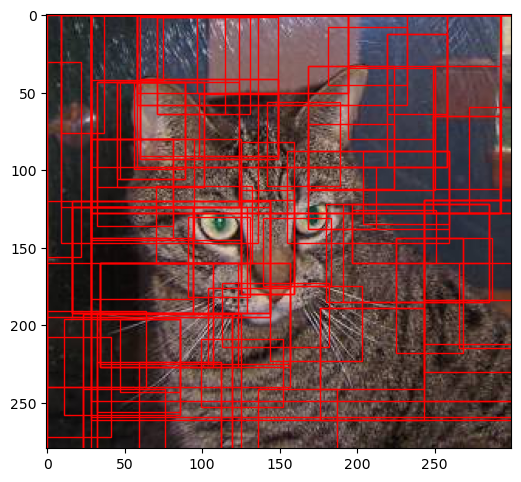

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Ordenamos las cajas por tamaño

sorted_boxes_by_size = sorted(boxes, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]), reverse=True)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(image)
count = 0

for box in sorted_boxes_by_size:
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)
    count += 1
    if count == 100:
        break

plt.show()

IoU
===
El IoU (Intersection over Union) es una métrica que se utiliza para medir la similitud entre dos regiones. Se define como el área de intersección entre dos regiones dividido por el área de unión.

<center>

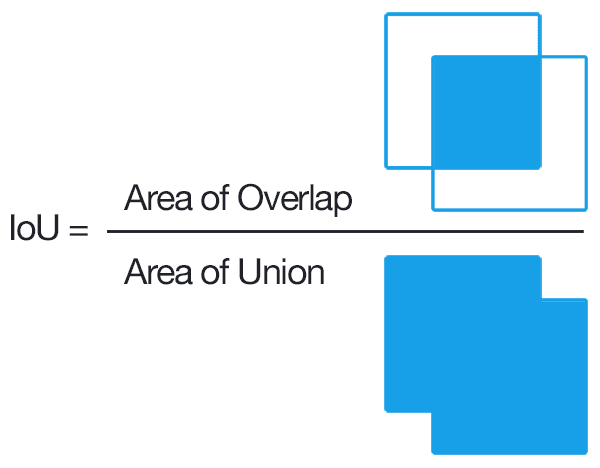

</center>

Non-maximum Suppression
=======================
Cuando aplicamos el algoritmo de Selective Search, obtenemos muchas regiones al rededor de un objeto. Para evitar tener muchas regiones apuntando al mismo objeto, se utiliza el algoritmo de Non-maximum Suppression (NMS). Este algoritmo consiste en eliminar las regiones que tienen un IoU mayor a un umbral $\tau$ con otra región que tiene un puntaje mayor.

Implementación
==============

Number of boxes:  8
Boxes:  [(0, 0, 300, 280), (28, 0, 300, 280), (28, 0, 300, 261), (28, 0, 300, 259), (28, 0, 300, 249), (28, 0, 300, 128), (28, 0, 293, 128), (28, 0, 292, 128)]


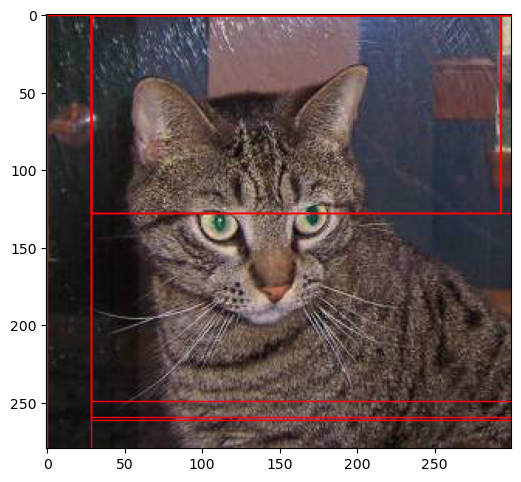

In [8]:
def intersection(ri, rj):

    x = max(ri[0], rj[0])
    y = max(ri[1], rj[1])
    w = min(ri[2], rj[2]) - x
    h = min(ri[3], rj[3]) - y

    if w < 0 or h < 0:
        return 0
    
    return w * h

def union(ri, rj, area_intersection):

    area_ri = (ri[2] - ri[0]) * (ri[3] - ri[1])
    area_rj = (rj[2] - rj[0]) * (rj[3] - rj[1])

    return area_ri + area_rj - area_intersection

def iou(ri, rj):

    if ri[0] >= ri[2] or ri[1] >= ri[3] or rj[0] >= rj[2] or rj[1] >= rj[3]:
        return 0
    
    area_i = intersection(ri, rj)
    area_u = union(ri, rj, area_i)

    return area_i / (area_u + 1e-6)

ground_truth = [(49, 38, 297, 278)]
boxes_to_analyze = sorted_boxes_by_size[:100]
filtered_boxes = []

# Analizamos las bounding boxes que tienen un IoU mayor de 0.3 con la ground truth
for box in boxes_to_analyze:
    iou_list = [iou(box, gt) for gt in ground_truth]
    if max(iou_list) > 0.3:
        filtered_boxes.append(box)

print("Number of boxes: ", len(filtered_boxes))
print("Boxes: ", filtered_boxes)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(image)

for box in filtered_boxes:
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)

plt.show()

R-CNN
=====
La idea de la RCNN es ejecutar el algoritmo de Selective Search para obtener las regiones de interés, luego, se extraen las características de cada región y se pasan a una CNN para clasificarlas. 

<center>

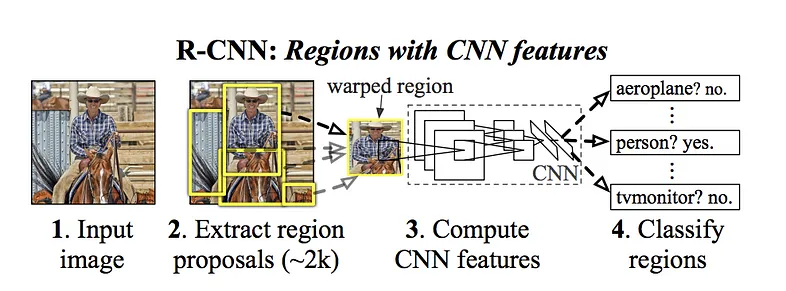

</center>

El problema de esta implementación es que es muy lenta, ya que se debe ejecutar el algoritmo de Selective Search para cada imágen. Implementemos una RCNN con fines didácticos.

Implementación
==============

In [9]:
from keras.preprocessing.image import ImageDataGenerator

# Generaremos imágenes de entrenamiento a partir del conjunto de datos para darle más variedad a las imágenes
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
training_set = train_datagen.flow_from_directory('datasets/training_set', target_size = (64, 64), batch_size = 32, class_mode = 'binary')

# Generaremos imágenes de test a partir del conjunto de datos para darle más variedad a las imágenes
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('datasets/test_set', target_size = (64, 64), batch_size = 32, class_mode = 'binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [10]:
# Activamos el uso de la GPU
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [11]:
import tensorflow as tf

# Creamos la red neuronal convolucional
cnn = tf.keras.models.Sequential()

# Primera capa de convolución
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Segunda capa de convolución
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Tercera capa de convolución
cnn.add(tf.keras.layers.Flatten())

# Capa de conexión
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compilamos la red neuronal
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn.fit(x = training_set, validation_data = test_set, epochs = 25)

Epoch 1/25
250/250 [==============================] - 27s 88ms/step - loss: 0.6494 - accuracy: 0.6049 - val_loss: 0.6088 - val_accuracy: 0.6705
Epoch 2/25
250/250 [==============================] - 21s 85ms/step - loss: 0.5683 - accuracy: 0.7057 - val_loss: 0.5183 - val_accuracy: 0.7545
Epoch 3/25
250/250 [==============================] - 21s 85ms/step - loss: 0.5350 - accuracy: 0.7324 - val_loss: 0.5575 - val_accuracy: 0.7220
Epoch 4/25
250/250 [==============================] - 21s 85ms/step - loss: 0.5130 - accuracy: 0.7494 - val_loss: 0.5152 - val_accuracy: 0.7505
Epoch 5/25
250/250 [==============================] - 21s 85ms/step - loss: 0.4794 - accuracy: 0.7717 - val_loss: 0.4774 - val_accuracy: 0.7750
Epoch 6/25
250/250 [==============================] - 21s 85ms/step - loss: 0.4715 - accuracy: 0.7753 - val_loss: 0.4566 - val_accuracy: 0.7915
Epoch 7/25
250/250 [==============================] - 21s 85ms/step - loss: 0.4472 - accuracy: 0.7849 - val_loss: 0.4552 - val_accuracy:

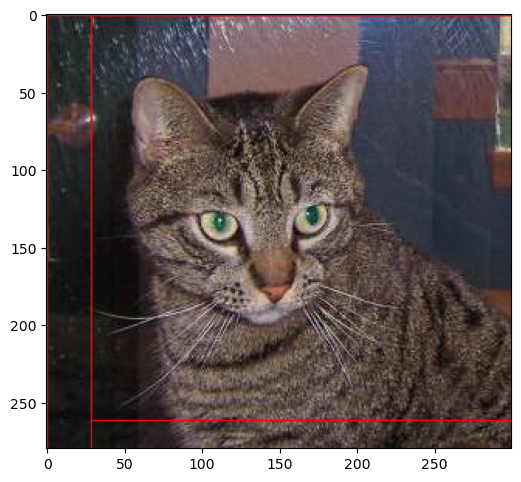

In [14]:
import cv2

# Analizamos las regiones que han pasado el filtro de IoU

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(image)
    
for box in filtered_boxes:

    x, y, w, h = box
    img = image[y:h, x:w, :]
    img_resized = cv2.resize(img, (64, 64))
    
    pred = cnn.predict(img_resized.reshape(1, 64, 64, 3))
    if pred[0][0] == 0:
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

plt.show()

Referencias:

https://www.kaggle.com/code/ritvik1909/object-detection-selective-search/notebook

https://programmerclick.com/article/71991839829/